In [1]:
import random
import torch
from d2l import torch as d2l

## 生成数据集

在这里使用人工生成数据集，生成一个包含1000个样本的数据集，每个样本包含从标准正态分布中采样的2个特征。即 $X \in R^{1000 \cdot 2}$

使用以下参数来生成数据集和标签

$$
w = 
\begin{bmatrix}
2 \\
-3.4
\end{bmatrix}

b = 4.2  \\
y = Xw+b + \epsilon
$$

其中 $\epsilon$ 视为模型预测和标签时潜在的观测误差。

In [2]:
def synthetic_data(w, b, num_examples):  
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))  # 生成1000*2的矩阵，数值从0-1正太分布中选取
    y = torch.matmul(X, w) + b                      # 矩阵相乘生成数据集y
    y += torch.normal(0, 0.01, y.shape)             # 生成0-0.01的扰动项
    return X, y.reshape(-1, 1)                      # 做成列向量返回，-1表示自动计算，如果后面的是1，这里就详单与1000

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [3]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([0.5390, 0.0264]) 
label: tensor([5.1961])


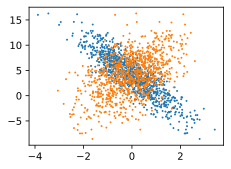

In [4]:
# 观察两个特征和labels之间的散点图
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)
d2l.plt.scatter(features[:, (0)].detach().numpy(), labels.detach().numpy(), 1)

## 读取数据集

在这里使用随机梯度下降，每次使用小批量数据来更新我们的模型。

In [5]:

def data_iter(batch_size:int,features:torch.tensor,labels:torch.tensor) :
    """随机读取数据

    Args:
        batch_size (int): 步长，随机读取的步长
    """
    num_examples = len(features)
    indices = list(range(num_examples))   # 索引
    random.shuffle(indices)               # 打乱索引
    
    for i in range(0,num_examples,batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size,num_examples)])     #防止数组越界
        yield features[batch_indices],labels[batch_indices]
    

In [6]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 2.1510,  1.2149],
        [-0.2481,  1.0119],
        [ 0.6982,  0.7404],
        [-1.0356, -0.0491],
        [-0.0172, -0.4402],
        [ 0.6370,  0.8171],
        [ 0.5807, -0.0584],
        [ 0.7685,  1.3628],
        [ 1.1387, -1.3085],
        [-1.0629,  0.8218]]) 
 tensor([[ 4.3645],
        [ 0.2680],
        [ 3.0801],
        [ 2.2969],
        [ 5.6592],
        [ 2.6934],
        [ 5.5655],
        [ 1.1161],
        [10.9201],
        [-0.7102]])


## 初始化模型参数


In [7]:
w = torch.normal(0,0.01,(2,1),requires_grad=True)
b = torch.zeros(1,requires_grad=True)
w,b

(tensor([[-0.0090],
         [ 0.0083]], requires_grad=True),
 tensor([0.], requires_grad=True))

## 定义模型

In [9]:
def linreg(X,w,b):
    return torch.matmul(X,w)+b   # y = Xw+b

## 定义损失函数

这里使用的是均方误差

In [10]:
# 需要注意的一点是：均方误差在这里并没有进行求均方的操作，因为要使用小批量随机梯度下降，因此在参数更新时除以对应的小批量

def square_loss(y_hat,y):
    return (y_hat-y.reshape(y_hat.shape)) **2 / 2   # 似乎不加reshape也可以正常运行，防止出现意外。这里除以2没有什么实际意义，在进行微分的时候比较好操作，第一次微分正好可以把2约掉

## 定义优化算法

尽管线性回归有解析解，但这里还是使用 ==小批量随机梯度下降==

In [11]:
def sgd(params,lr,batch_size):
    
    with torch.no_grad():                           # 更新参数的时候，不进行求导
        for param in params:
            param -= lr * param.grad / batch_size   # 参数的跟新。这里是一组小批量数据，因此要除以批量数，得到每个样本（在定义损失函数的时候，我们并没有对其取均值，在这里进行操作）
            param.grad.zero_()                      # 因为求导梯度会累积，每次更新完参数要将参数设置为0，这里参数设置为0用param.grad_zero_()

In [12]:
w


tensor([[-0.0090],
        [ 0.0083]], requires_grad=True)

## 模型开始训练

In [13]:



lr = 0.03
num_epochs = 3    # 迭代次数
net = linreg  # 网络
loss = square_loss   # 损失函数

# 注意在这里我们使用一组数据训练一个w,b参数。并非之前所想的每一个样本训练一个w,b。当小批量为1的时候就是每一个样本训练一个w，b。
# 由于在这里是使用一个小批量来训练一组数据，因此在进行参数更新的 时候要除以小批量
for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l = loss(net(X,w,b),y)      # X,y的小批量损失,# 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        l.sum().backward()          # l.sum().backward() 相当于 l.backward(torch.len(x)) 对其中每一个分量求偏导
        sgd([w,b],lr,batch_size)    #使用梯度跟新参数
    with torch.no_grad():           # 在进行求评价指标的时候也是不需要进行自动微分
        train_l = loss(net(features,w,b),labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')
        


Traceback (most recent call last):
  File "C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\debugpy\_vendored\pydevd\_pydevd_bundle\pydevd_vars.py", line 620, in change_attr_expression
    value = eval(expression, frame.f_globals, frame.f_locals)
  File "<string>", line 1, in <module>
NameError: name 'tensor' is not defined


epoch 1, loss 0.039982
epoch 2, loss 0.000158
epoch 3, loss 0.000048


In [59]:
w

tensor([[ 1.9998],
        [-3.3994]], requires_grad=True)

In [60]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0002, -0.0006], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0003], grad_fn=<RsubBackward1>)
